In [31]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import torch
import codecs
import numpy as np
from random import randint
from tqdm import tnrange, tqdm_notebook
import csv
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

def flatten_matrix(matrix):
    vector = matrix.flatten(order='F')
    vector = vector.reshape(1, len(vector))
    return vector

def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T) #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=True,
                              sqrt_bias=10, min_divisor=1e-8):

    """
    __author__ = "David Warde-Farley"
    __copyright__ = "Copyright 2012, Universite de Montreal"
    __credits__ = ["David Warde-Farley"]
    __license__ = "3-clause BSD"
    __email__ = "wardefar@iro"
    __maintainer__ = "David Warde-Farley"
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor

    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, np.newaxis]  
    else:
        X = X.copy()
    if use_std:
        ddof = 1
        if X.shape[1] == 1:
            ddof = 0
        normalizers = np.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = np.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale
    normalizers[normalizers < min_divisor] = 1.
    X /= normalizers[:, np.newaxis]  # Does not make a copy.
    return X

def ZeroCenter(data):
    data = data - np.mean(data,axis=0)
    return data

def Zerocenter_ZCA_whitening_Global_Contrast_Normalize(list):
    Intonumpyarray = np.asarray(list)
    data = Intonumpyarray.reshape(48,48)
    data2 = ZeroCenter(data)
    data3 = zca_whitening(flatten_matrix(data2)).reshape(48,48)
    data4 = global_contrast_normalize(data3)
    data5 = np.rot90(data4,3)
    return data5    


def load_data():

    train_x = []
    train_y = []
    val_x =[]
    val_y =[]

    with open("badtrainingdata.txt", "r") as text:
        ToBeRemovedTrainingData = []
        for line in text:
            ToBeRemovedTrainingData.append(int(line))
    number = 0

    f = open('fer2013.csv')
    csv_f = csv.reader(f)

    for row in csv_f:   
        number+= 1
        if number not in ToBeRemovedTrainingData:

            if str(row[2]) == "Training" or str(row[2]) == "PublicTest" :
                temp_list = []

                for pixel in row[1].split( ):
                    temp_list.append(int(pixel))

                data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
                train_y.append(int(row[0]))
                train_x.append(data.reshape(48,48).tolist())

            elif str(row[2]) == "PrivateTest":
                temp_list = []

                for pixel in row[1].split( ):
                    temp_list.append(int(pixel))

                data = Zerocenter_ZCA_whitening_Global_Contrast_Normalize(temp_list)
                val_y.append(int(row[0]))
                val_x.append(data.reshape(48,48).tolist())

    return train_x, train_y, val_x, val_y



In [32]:
def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Applies the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=1,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.deg2rad(np.random.uniform(-rg, rg))
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_vertical_flip(x, p=0.5):
    """Performs a random Vertical Flip.
    # Arguments
        x: Input tensor. Must be 3D.
    # Returns
        Flipped tensor
    """
    sal = np.copy(x)
    for i in np.ndindex(x.shape[:1]):
        if np.random.random() < p:
            sal[i] = flip_axis(sal[i], 1)
    return sal

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

In [33]:
class facialRecognitionDataset(data.Dataset):
    """facialRecognitionDataset Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        self.transform = transform
        self.target_transform = target_transform
        

        self.convert_data()
        
        if not self._check_exists():
            raise RuntimeError('Dataset not found.')

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(root, self.processed_folder, self.training_file))
            
            self.random_affine()
            self.y_train_tensor = torch.LongTensor(self.train_labels)
        else:
            self.test_data, self.test_labels = torch.load(os.path.join(root, self.processed_folder, self.test_file))

            self.x_test_tensor = torch.FloatTensor(self.test_data).view(-1, 48, 48)
            self.y_test_tensor = torch.LongTensor(self.test_labels) 

        
        print("init_facial")

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        
        if self.train:
            img, target = self.x_train_tensor[index], self.y_train_tensor[index]
        else:
            img, target = self.x_test_tensor[index], self.y_test_tensor[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        img2 = img.unsqueeze(0)
            
        return img2, target

    def __len__(self):
        if self.train:
            return 32181
        else:
            return 3589

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def random_affine(self):
        self.train_data_random = np.copy(self.train_data)
        self.train_data_random = random_rotation(self.train_data_random,5)
        self.train_data_random = random_shift(self.train_data_random,0.1,0.1)
        self.train_data_random = random_vertical_flip(self.train_data_random)
        self.x_train_tensor = torch.FloatTensor(self.train_data_random).view(-1, 48, 48)
        
        
    def convert_data(self):
        """Convert data files."""
        
        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # process and save as torch files
        print('Processing...')
        
        x_train, y_train, x_test, y_test = load_data()

        #x_train = torch.FloatTensor(X).view(-1, 48, 48)
        #y_train = torch.LongTensor(Y)
        #x_test = torch.FloatTensor(X_test).view(-1, 48, 48)
        #y_test = torch.LongTensor(Y_test)        
        
        training_set = (
            x_train,
            y_train
        )
        test_set = (
            x_test,
            y_test
        )
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

In [34]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time

In [35]:
# Training settings
batch_size = 64
is_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if is_cuda else {}
train_loader = torch.utils.data.DataLoader(
    facialRecognitionDataset('../data198', train=True,
                   transform=None),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    facialRecognitionDataset('../data198', train=False,
               transform=None),
    batch_size=batch_size, shuffle=True, **kwargs)

init_facial
init_facial


In [36]:
train_loader.batch_size

64

In [37]:
loaded = False
for batch_idx, (data, target) in enumerate(train_loader):
    if loaded == False:
        data2 = data
        target2 = target
        loaded = True


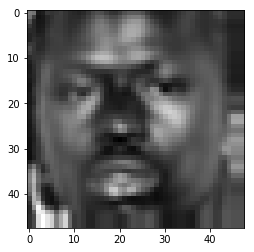

In [38]:
plt.imshow(data2[1][0].numpy(), cmap='gray')
plt.show()

In [39]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_map = len(label_map)
X2, Y2 = data2.numpy(), target2.numpy()
while True:
    fig, axes = plt.subplots(1, num_map, figsize=(16, 32),subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    i=0
    for ax, i in zip(axes.flat, np.linspace(0, num_map, num_map, endpoint=False)):
        x, y = X2[Y2==i], Y2[Y2==i]
        N = len(y)
        j = np.random.choice(N)
        ax.imshow(x[j][0].reshape(48, 48), cmap='gray')
        ax.set_title(label_map[y[j]])
    plt.show()
    prompt = input('Quit? Enter Y:\n')
    if prompt == 'Y':
        break

ValueError: a must be greater than 0

In [40]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.mp = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.avgp1 = nn.AvgPool2d(kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.avgp2 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 7)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(self.mp(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(self.avgp1(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.avgp2(x))
        x = x.view(in_size, -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.drop(x)))
        x = F.relu(self.fc3(self.drop(x)))
        return F.log_softmax(x,dim=1)

In [41]:
model = Net()
if is_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [42]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [43]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [44]:
start_time = time.time()
for epoch in tqdm_notebook(range(80), desc='train cnn...'):
    train(epoch)
    train_loader.dataset.random_affine()
    test()

Exception in thread Thread-328:
Traceback (most recent call last):
  File "/anaconda3/envs/tfdeeplearning/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/envs/tfdeeplearning/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Test set: Average loss: 1.9459, Accuracy: 491/3589 (14%)
Test set: Average loss: 1.9459, Accuracy: 491/3589 (14%)
Test set: Average loss: 1.9459, Accuracy: 491/3589 (14%)
Test set: Average loss: 1.9106, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8959, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8947, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8946, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8907, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8899, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8899, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8900, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8896, Accuracy: 879/3589 (24%)
Test set: Average loss: 1.8898,